# Task 1

## Import necessary libraries

In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import datetime
import warnings

# Download NLTK resources
nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('stopwords')

# Set up Seaborn
sns.set(style="whitegrid")

# Ignore warnings
warnings.filterwarnings("ignore")

# Load the dataset
data_path = "../data/raw_analyst_ratings.csv"
df = pd.read_csv(data_path)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\matiwos.desalegn\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\matiwos.desalegn\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\matiwos.desalegn\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Descriptive Statistics

### Display the first few rows of the dataset

In [ ]:
# Display the first few rows of the dataset
df.head()

,Unnamed: 0,headline,url,publisher,date,stock
0,0,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,2020-06-05 10:30:54-04:00,A
1,1,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,2020-06-03 10:45:20-04:00,A
2,2,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,2020-05-26 04:30:07-04:00,A
3,3,46 Stocks Moving In Friday's Mid-Day Session,https://www.benzinga.com/news/20/05/16095921/4...,Lisa Levin,2020-05-22 12:45:06-04:00,A
4,4,B of A Securities Maintains Neutral on Agilent...,https://www.benzinga.com/news/20/05/16095304/b...,Vick Meyer,2020-05-22 11:38:59-04:00,A


### Check the data types and missing values

In [ ]:
# Check the data types and missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1407328 entries, 0 to 1407327
Data columns (total 6 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   Unnamed: 0  1407328 non-null  int64 
 1   headline    1407328 non-null  object
 2   url         1407328 non-null  object
 3   publisher   1407328 non-null  object
 4   date        1407328 non-null  object
 5   stock       1407328 non-null  object
dtypes: int64(1), object(5)
memory usage: 64.4+ MB


### The task involves analyzing textual lengths, counting articles per publisher, and studying publication date trends to understand news frequency.

Number of duplicate rows: 0
Missing values:
 Unnamed: 0    0
headline      0
url           0
publisher     0
date          0
stock         0
dtype: int64
Headline Length Statistics:
 count    1.407328e+06
mean     7.312051e+01
std      4.073531e+01
min      3.000000e+00
25%      4.700000e+01
50%      6.400000e+01
75%      8.700000e+01
max      5.120000e+02
Name: headline_length, dtype: float64
Number of articles per publisher:
 publisher
Paul Quintaro        228373
Lisa Levin           186979
Benzinga Newsdesk    150484
Charles Gross         96732
Monica Gerson         82380
Name: count, dtype: int64
Publication Date Counts:
 publication_date
2009-02-14    1
2009-04-27    2
2009-04-29    1
2009-05-22    1
2009-05-27    6
Name: count, dtype: int64


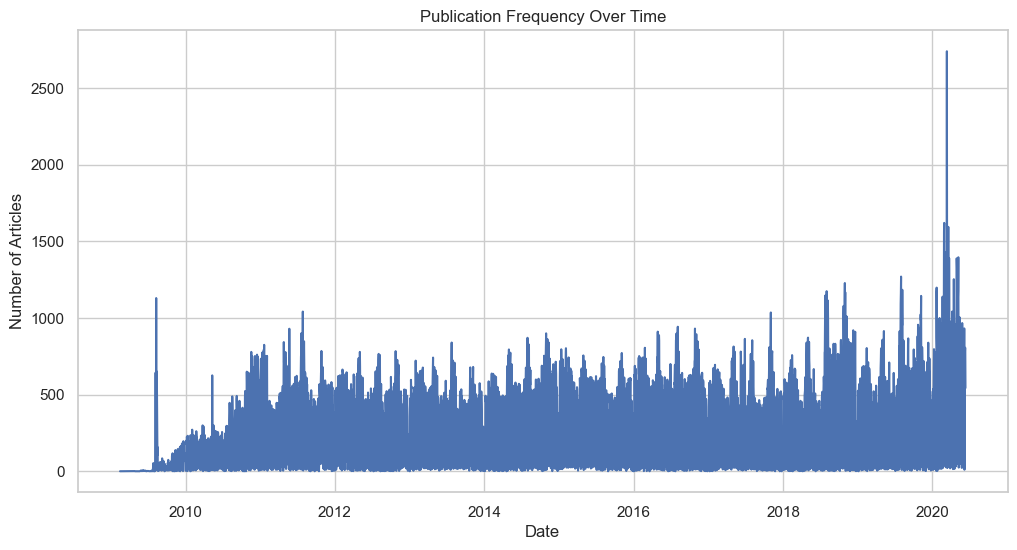

In [ ]:
# Convert 'date' column to datetime format
# df['date'] = pd.to_datetime(df['date'], format="%Y-%m-%d %H:%M:%S", utc=True)
df['date'] = pd.to_datetime(df['date'], format='ISO8601')
# Check for duplicate rows
duplicate_rows = df[df.duplicated()]
print("Number of duplicate rows:", duplicate_rows.shape[0])

# Drop duplicate rows if any
df = df.drop_duplicates()

# Check for missing values
missing_values = df.isnull().sum()
print("Missing values:\n", missing_values)

# Drop rows with missing values
df = df.dropna()

# Basic statistics for textual lengths (headline length)
df['headline_length'] = df['headline'].apply(lambda x: len(str(x)))
headline_stats = df['headline_length'].describe()
print("Headline Length Statistics:\n", headline_stats)

# Count the number of articles per publisher
publisher_counts = df['publisher'].value_counts()
print("Number of articles per publisher:\n", publisher_counts.head())

# Analyze the publication dates to see trends over time
df['publication_date'] = df['date'].dt.date
date_counts = df['publication_date'].value_counts().sort_index()
print("Publication Date Counts:\n", date_counts.head())

# Plot publication frequency over time
plt.figure(figsize=(12, 6))
date_counts.plot(kind='line')
plt.title('Publication Frequency Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Articles')
plt.show()

## Text Analysis(Sentiment analysis & Topic Modeling) Using NLTK and VADER model

### Sentiment Analysis

Sentiment Counts:
 sentiment_category
neutral     731893
positive    448740
negative    226695
Name: count, dtype: int64


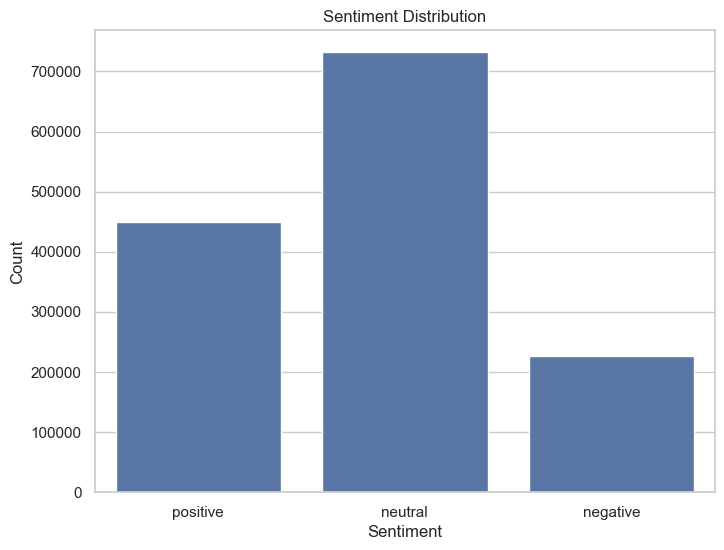

In [ ]:
# Initialize the Sentiment Intensity Analyzer
sid = SentimentIntensityAnalyzer()

# Perform sentiment analysis on headlines
df['sentiment'] = df['headline'].apply(lambda x: sid.polarity_scores(x)['compound'])

# Categorize sentiment
df['sentiment_category'] = df['sentiment'].apply(lambda x: 'positive' if x > 0 else ('negative' if x < 0 else 'neutral'))

# Count sentiment categories
sentiment_counts = df['sentiment_category'].value_counts()
print("Sentiment Counts:\n", sentiment_counts)

# Plot sentiment distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='sentiment_category', data=df, order=['positive', 'neutral', 'negative'])
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

### Topic Modeling using Latent Dirichlet Allocation (LDA).

Top words for each topic:
Topic 1:
vs est eps reports sales sees estimate q4 q1 q2
Topic 2:
pt buy downgrades upgrades target maintains raises price 00 initiates
Topic 3:
stocks market mid week 52 session update day moving pre
Topic 4:
earnings top benzinga stocks scheduled may watch 2018 analyst etfs
Topic 5:
shares trading says us companies higher announces stock lower several


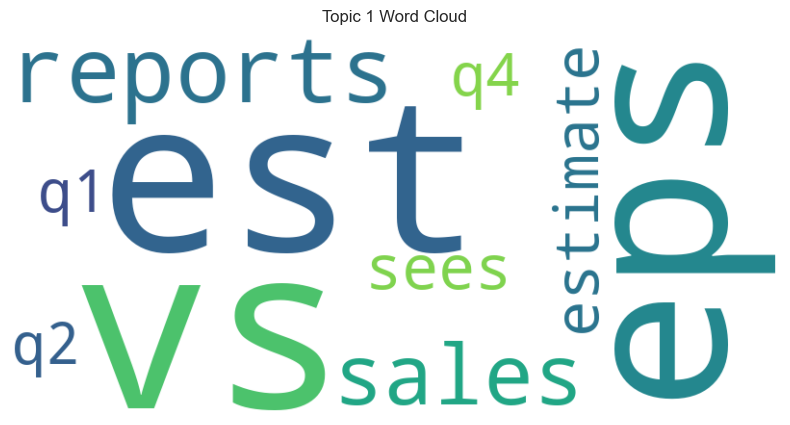

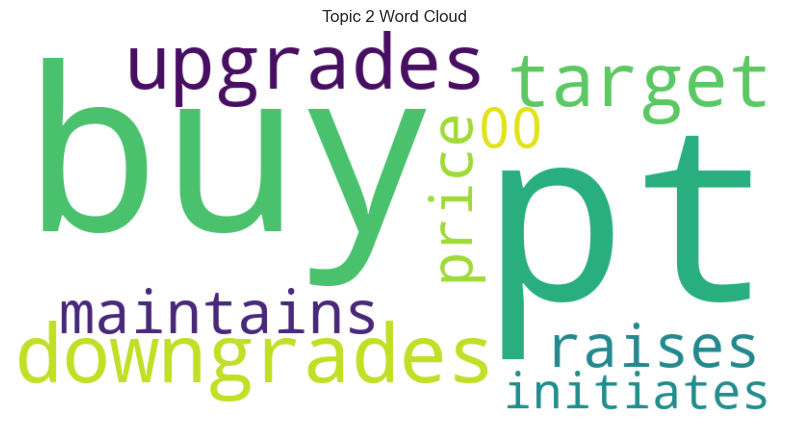

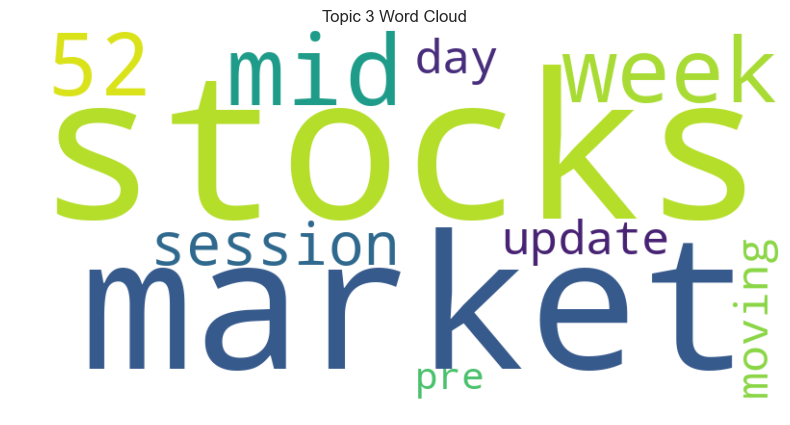

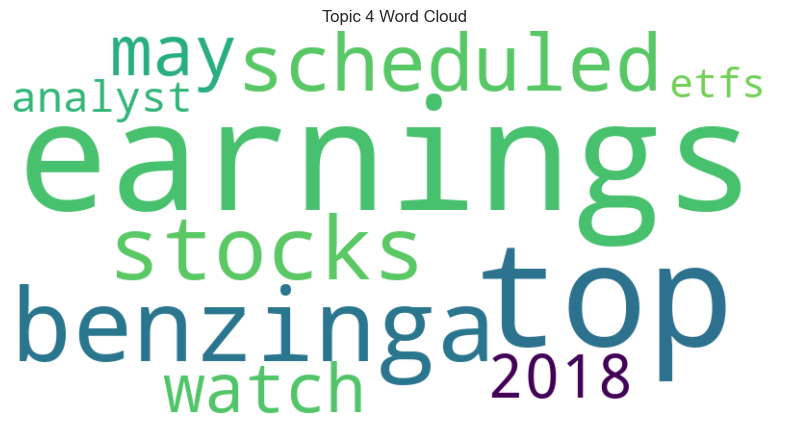

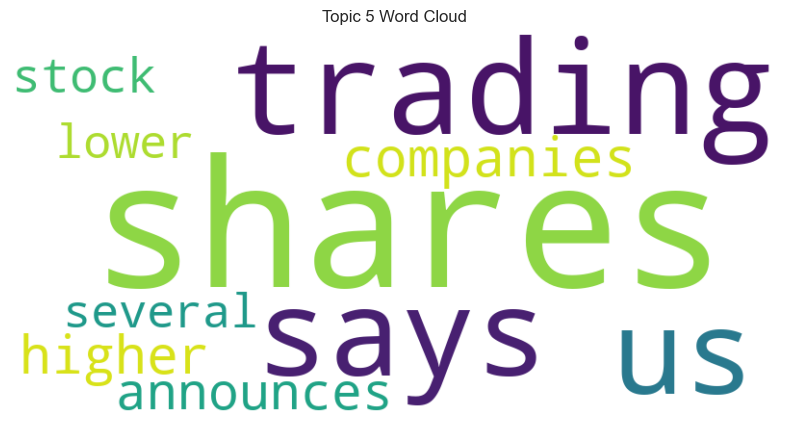

In [ ]:
# Tokenize words in headlines
df['tokens'] = df['headline'].apply(lambda x: word_tokenize(x.lower()))

# Remove stopwords
stop_words = set(stopwords.words('english'))
df['filtered_tokens'] = df['tokens'].apply(lambda x: [word for word in x if word not in stop_words])

# Convert tokens back to string for CountVectorizer
df['clean_headline'] = df['filtered_tokens'].apply(lambda x: ' '.join(x))

# Vectorize text using CountVectorizer
vectorizer = CountVectorizer(max_features=1000)
X = vectorizer.fit_transform(df['clean_headline'])

# Perform Latent Dirichlet Allocation (LDA)
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(X)

# Display top words for each topic
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx + 1))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 10
print("Top words for each topic:")
display_topics(lda, vectorizer.get_feature_names_out(), no_top_words)

# Plot word cloud for each topic
def plot_word_cloud(lda_model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(lda_model.components_):
        word_dict = {}
        for i in topic.argsort()[:-no_top_words - 1:-1]:
            word_dict[feature_names[i]] = topic[i]
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_dict)
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title('Topic ' + str(topic_idx + 1) + ' Word Cloud')
        plt.show()

plot_word_cloud(lda, vectorizer.get_feature_names_out(), no_top_words)

### VADER Seniment Scoring

In [ ]:
# Initialize the Sentiment Intensity Analyzer
sid = SentimentIntensityAnalyzer()

# Perform sentiment analysis on headlines
df['sentiment'] = df['headline'].apply(lambda x: sid.polarity_scores(x))

# Extract negative, neutral, and positive scores
df['neg'] = df['sentiment'].apply(lambda x: x['neg'])
df['neu'] = df['sentiment'].apply(lambda x: x['neu'])
df['pos'] = df['sentiment'].apply(lambda x: x['pos'])

#### Plot VADER results

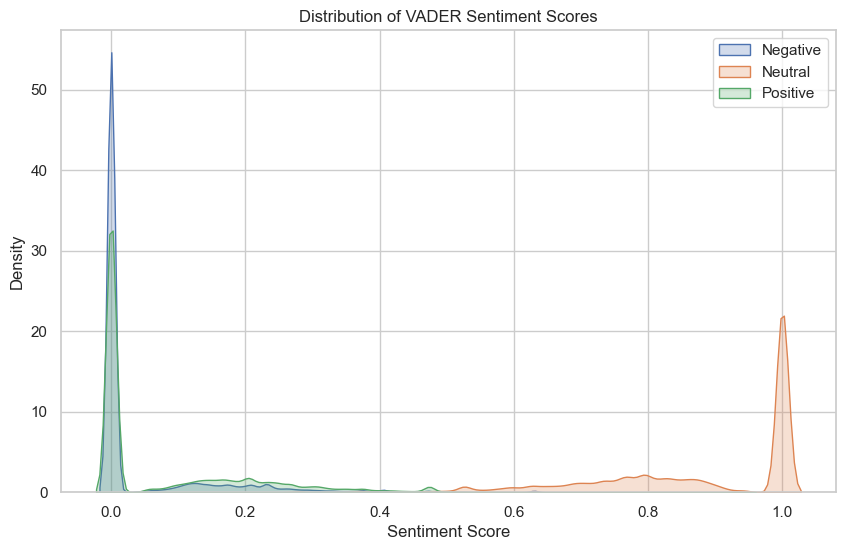

In [ ]:
# Plot VADER results
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df['neg'], label='Negative', shade=True)
sns.kdeplot(data=df['neu'], label='Neutral', shade=True)
sns.kdeplot(data=df['pos'], label='Positive', shade=True)
plt.title('Distribution of VADER Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Density')
plt.legend()
plt.show()

## Time Series Analysis

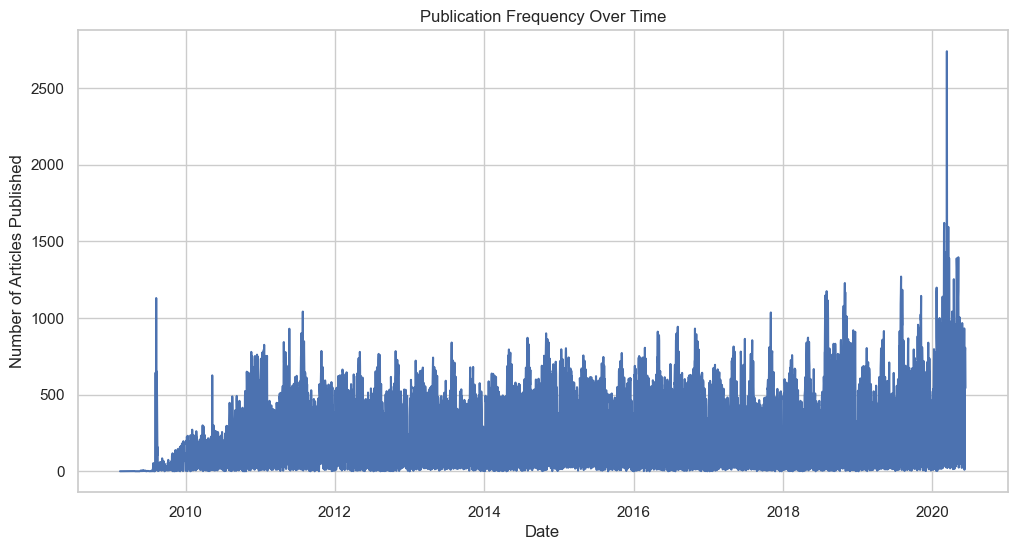

In [ ]:
# Convert 'date' column to datetime format
df['date'] = pd.to_datetime(df['date'], format='ISO8601')
# Group data by publication date and count the number of articles published each day
publication_frequency = df.groupby(df['date'].dt.date).size()

# Plot publication frequency over time
plt.figure(figsize=(12, 6))
publication_frequency.plot(kind='line')
plt.title('Publication Frequency Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Articles Published')
plt.grid(True)
plt.show()

### Identify spikes in article publications related to specific market events.

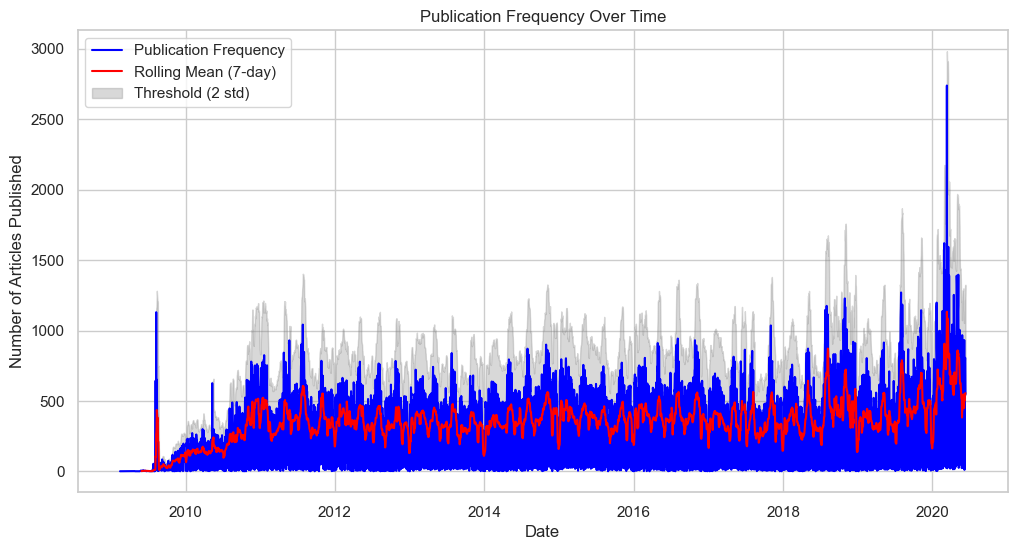

In [ ]:
# Group data by publication date and count the number of articles published each day
publication_frequency = df.groupby(df['date'].dt.date).size()

# Calculate rolling mean and standard deviation to identify spikes
rolling_mean = publication_frequency.rolling(window=7).mean()
rolling_std = publication_frequency.rolling(window=7).std()

# Define threshold for spikes (e.g., 2 standard deviations from the mean)
threshold = rolling_mean + (2 * rolling_std)

# Plot publication frequency over time
plt.figure(figsize=(12, 6))
plt.plot(publication_frequency.index, publication_frequency, label='Publication Frequency', color='blue')
plt.plot(rolling_mean.index, rolling_mean, label='Rolling Mean (7-day)', color='red')
plt.fill_between(rolling_std.index, threshold, rolling_mean, color='gray', alpha=0.3, label='Threshold (2 std)')
plt.title('Publication Frequency Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Articles Published')
plt.legend()
plt.grid(True)

# Overlay significant market events on the plot (if available)
# For example:
# plt.axvline(x='2023-01-01', color='green', linestyle='--', label='Market Event 1')
# plt.axvline(x='2023-03-15', color='orange', linestyle='--', label='Market Event 2')

plt.show()

## Publisher Analysis

In [ ]:
# Extract unique domains from publishers (if email addresses used)
df['publisher_domain'] = df['publisher'].str.split('@').str[-1]

# Count articles per unique publisher domain
publisher_domain_counts = df['publisher_domain'].value_counts()
print("Number of articles per unique publisher domain:\n", publisher_domain_counts.head())


Number of articles per unique publisher domain:
 publisher_domain
Paul Quintaro        228373
Lisa Levin           186979
Benzinga Newsdesk    150484
Charles Gross         96732
Monica Gerson         82380
Name: count, dtype: int64


### Difference in News Type

<Figure size 1200x600 with 0 Axes>

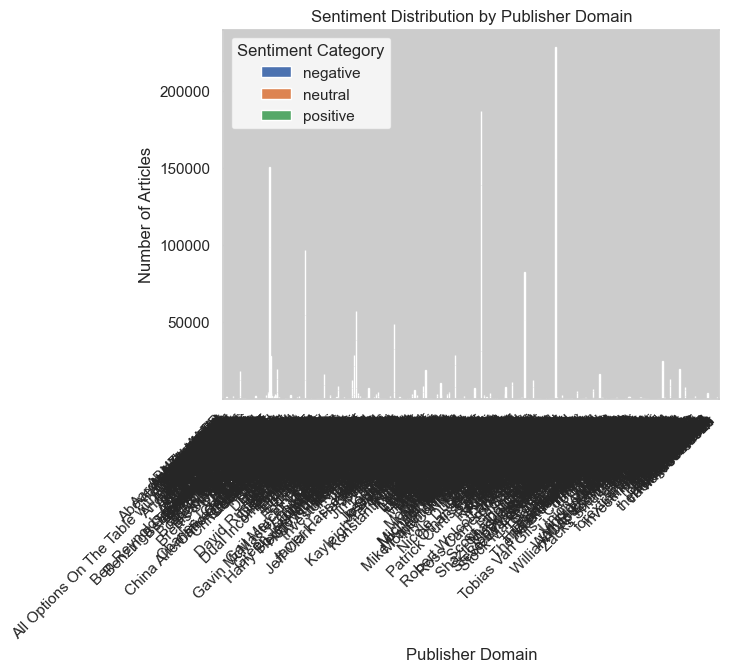

In [ ]:
# Group data by publisher domain and sentiment category, and count the number of articles
publisher_sentiment_counts = df.groupby(['publisher_domain', 'sentiment_category']).size().unstack(fill_value=0)

# Plot stacked bar chart to visualize sentiment distribution by publisher domain
plt.figure(figsize=(12, 6))
publisher_sentiment_counts.plot(kind='bar', stacked=True)
plt.title('Sentiment Distribution by Publisher Domain')
plt.xlabel('Publisher Domain')
plt.ylabel('Number of Articles')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Sentiment Category')
plt.show()


### Identify unique domains from email addresses used as publisher names:

In [ ]:
# Filter publisher names that contain '@' to identify email addresses
email_publishers = df[df['publisher'].str.contains('@')]

# Extract unique domains from email publishers
email_publishers['publisher_domain'] = email_publishers['publisher'].str.split('@').str[-1]

# Count articles per unique publisher domain
email_publisher_domain_counts = email_publishers['publisher_domain'].value_counts()

print("Number of articles per unique email publisher domain:\n", email_publisher_domain_counts.head())

Number of articles per unique email publisher domain:
 publisher_domain
benzinga.com      7937
gmail.com          139
andyswan.com         5
investdiva.com       2
tothetick.com        2
Name: count, dtype: int64
